In [1]:
from src.model import ValuePolicyNetwork
from src.env import *
import torch
import random
from src.solver import solve_cube

# Prepare model
device = torch.device("cpu")
model = ValuePolicyNetwork()
model.load_state_dict(torch.load("../models/model.pth", map_location=device , weights_only=False))
model.to(device)
model.eval()

ValuePolicyNetwork(
  (shared_layers): Sequential(
    (0): Linear(in_features=480, out_features=4096, bias=True)
    (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=4096, out_features=2048, bias=True)
    (4): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (5): ELU(alpha=1.0)
  )
  (value_head): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
  (policy_head): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [29]:
metrics = {}

# Try to solve 100 cubes for k from 1 to 8
for scramble_length in range(1, 9):

    scramble_metrics = {"success_rate": 0, "solve_time": [], "iterations": [], "path_len": []}

    # Test solving multiple scrambled cubes
    num_cubes = 100
    solved_count = 0

    total_time = 0
    total_iterations = 0

    print(f"\nTesting solver on {num_cubes} cubes scrambled with {scramble_length} moves each...")

    for cube_num in range(num_cubes):
        cube = Cube()
        scramble_moves = []
        
        # Generate the disassembled cube
        for _ in range(scramble_length):
            appended = False
            move_index = 0
            while not appended:
                move_index = random.randint(0, 11)
                if len(scramble_moves) == 0:
                    appended = True
                    continue
                if move_index%2 == 0 and scramble_moves[-1] == move_index + 1:
                    continue
                if move_index%2 == 1 and scramble_moves[-1] == move_index - 1:
                    continue
                appended = True
            cube.move(move_index)
            scramble_moves.append(move_index)

        print(f"\nCube {cube_num + 1}")
        print(f"Scramble sequence: {scramble_moves}")
        
        # Try to solve the cube
        corners, edges = cube.get_state()
        solution, solve_time, iterations, solved, solution_actions = solve_cube(
            initial_state=(corners, edges),
            max_exploration=60_000,
            action_set=list(range(12)),
            model=model,
            device=device,
        )

        if solved:
            scramble_metrics["success_rate"] += 1
            scramble_metrics["solve_time"].append(solve_time)
            scramble_metrics["iterations"].append(iterations)
            scramble_metrics["path_len"].append(len(solution_actions))
            solved_count += 1

        total_time += solve_time
        total_iterations += iterations

        print(f"Solution found: {solved}")
        print(f"Solve time: {solve_time:.2f}s")
        print(f"Iterations: {iterations}")

    success_rate = (solved_count / num_cubes) * 100
    avg_time = total_time / num_cubes
    avg_iterations = total_iterations / num_cubes

    metrics[scramble_length] = scramble_metrics

    print(f"\nResults:")
    print(f"Success rate: {success_rate:.1f}%")
    print(f"Average solve time: {avg_time:.2f}s")
    print(f"Average iterations: {avg_iterations:.1f}")


Testing solver on 100 cubes scrambled with 8 moves each...

Cube 1
Scramble sequence: [3, 6, 1, 6, 8, 11, 7, 3]
Solution: [2, 6, 10, 9, 7, 0, 7, 2]
Solution found: True
Solve time: 0.12s
Iterations: 42

Cube 2
Scramble sequence: [11, 6, 3, 3, 7, 10, 10, 10]
Solution: [10, 6, 3, 3, 7, 10]
Solution found: True
Solve time: 0.03s
Iterations: 11

Cube 3
Scramble sequence: [3, 9, 3, 6, 0, 6, 8, 6]


/home/john/repos/RubikCube/src/solver.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cube = Cube(torch.tensor(corners.clone()), torch.tensor(edges.clone()))


Solution found: False
Solve time: 82.43s
Iterations: 60000

Cube 4
Scramble sequence: [1, 11, 6, 4, 0, 6, 11, 1]
Solution: [0, 10, 7, 1, 7, 5, 10, 0]
Solution found: True
Solve time: 2.21s
Iterations: 1476

Cube 5
Scramble sequence: [6, 1, 1, 7, 2, 5, 7, 5]
Solution: [4, 4, 6, 3, 6, 0, 0, 7]
Solution found: True
Solve time: 0.29s
Iterations: 129

Cube 6
Scramble sequence: [11, 0, 6, 11, 4, 1, 4, 10]
Solution: [11, 5, 0, 5, 10, 7, 1, 10]
Solution found: True
Solve time: 1.54s
Iterations: 338

Cube 7
Scramble sequence: [5, 8, 7, 7, 9, 4, 1, 11]
Solution found: False
Solve time: 71.54s
Iterations: 60000

Cube 8
Scramble sequence: [9, 2, 7, 4, 8, 4, 8, 11]
Solution found: False
Solve time: 74.27s
Iterations: 60000

Cube 9
Scramble sequence: [10, 10, 8, 5, 7, 4, 6, 1]
Solution: [0, 9, 10, 10]
Solution found: True
Solve time: 0.01s
Iterations: 4

Cube 10
Scramble sequence: [11, 11, 0, 4, 10, 9, 3, 0]
Solution: [1, 8, 2, 11, 5, 1, 10, 10]
Solution found: True
Solve time: 0.03s
Iterations: 9



In [35]:
import pickle

with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [31]:
import pickle

with open('metrics', 'rb') as f:
    metrics = pickle.load(f)

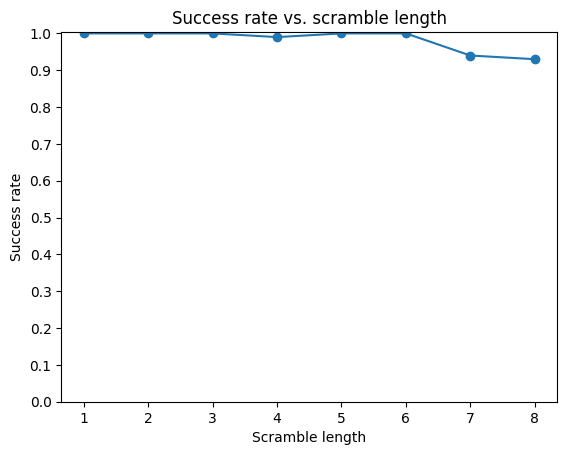

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Plot success rate

success_rates = {}
for scramble_length in range(1, 9):
    success_rates[scramble_length] = metrics[scramble_length]["success_rate"] / 100

fig, ax = plt.subplots()
ax.plot(list(range(1, 9)), success_rates.values(), marker='o', linestyle='-')
ax.set_xlabel('Scramble length')
ax.set_ylabel('Success rate')
ax.set_title('Success rate vs. scramble length')
ax.set_xticks(list(range(1, 9)))
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Save the plot
fig.savefig('../resources/success_rate.png')

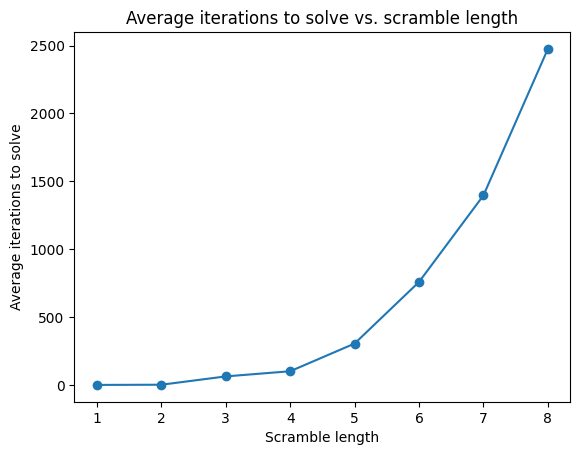

In [33]:
# Plot average iterations

avg_iterations = {}
for scramble_length in range(1, 9):
    avg_iterations[scramble_length] = np.mean(metrics[scramble_length]["iterations"])

fig, ax = plt.subplots()
ax.plot(list(range(1, 9)), avg_iterations.values(), marker='o', linestyle='-')
ax.set_xlabel('Scramble length')
ax.set_ylabel('Average iterations to solve')
ax.set_title('Average iterations to solve vs. scramble length')
ax.set_xticks(list(range(1, 9)))

# Save the plot
fig.savefig('../resources/avg_iterations.png')

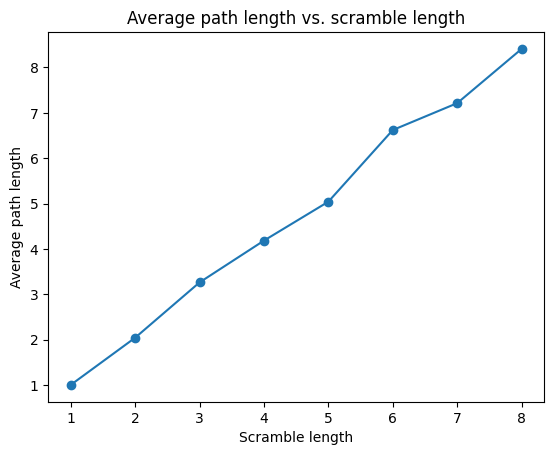

In [34]:
# Plot average path length

avg_path_len = {}
for scramble_length in range(1, 9):
    avg_path_len[scramble_length] = np.mean(metrics[scramble_length]["path_len"])

fig, ax = plt.subplots()
ax.plot(list(range(1, 9)), avg_path_len.values(), marker='o', linestyle='-')
ax.set_xlabel('Scramble length')
ax.set_ylabel('Average path length')
ax.set_title('Average path length vs. scramble length')
ax.set_xticks(list(range(1, 9)))

# Save the plot
fig.savefig('../resources/avg_path_len.png')